In [1]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import json
import numpy as np
from PIL import ImageDraw
from data.base_dataset import BaseDataset, get_params, get_transform
import models.networks as networks
import torch.utils.data as data
from torch.autograd import Variable

In [2]:
class Args:
    name = 'label2city'
    gpu_ids = [0, 1, 2, 3]
    checkpoints_dir = './checkpoints'
    model = 'pix2pixHD'
    norm = 'instance'
    use_dropout = True
    verbose = True
    batchSize = 1
    loadSAize = 512
    fineSize = 512
    label_nc = 20
    input_nc = 3
    output_nc = 3
    dataroot = '../../after_vton_difficult_v2'
    datapairs = 'single_pairs.txt'
    resize_or_crop = 'scale_width'
    serial_batches = True
    no_flip = True
    nThreads = 2
    max_dataset_size = float("inf")
    display_winsize = 512
    tf_log = True
    netG = 'global'
    ngf = 64
    n_downsample_global = 4
    n_blocks_global = 4
    n_blocks_local = 3
    n_local_enhancers = 1
    niter_fix_global = 0
    continue_train = True
    display_freq = 100
    print_freq = 100
    save_latest_freq = 1000
    save_epoch_freq = 10 
    no_html = True
    debug = True
    load_pretrain = '../label2city'
    which_epoch = 'latest'
    phase = 'test'
    niter = 100
    niter_decay = 100
    beta1 = 0.5
    lr = 0.0002
    num_D = 2
    n_layers_D = 3
    ndf = 64
    lambda_feat = 10.0
    no_ganFeat_loss = True
    no_vgg_loss = False
    no_lsgan = True
    pool_size = 0
    isTrain = True

opt = Args

In [3]:
def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    f = dir.split('/')[-1].split('_')[-1]
    dirs= os.listdir(dir)
    for img in dirs:

        path = os.path.join(dir, img)
        #print(path)
        images.append(path)
    return images

In [4]:
def get_params(opt, size):
    w, h = size
    new_h = h
    new_w = w
    if opt.resize_or_crop == 'resize_and_crop':
        new_h = new_w = opt.loadSize            
    elif opt.resize_or_crop == 'scale_width_and_crop':
        new_w = opt.loadSize
        new_h = opt.loadSize * h // w

    x = random.randint(0, np.maximum(0, new_w - opt.fineSize))
    y = random.randint(0, np.maximum(0, new_h - opt.fineSize))

def get_transform(method=Image.BICUBIC, normalize=True):
        transform_list = []
        transform_list += [transforms.ToTensor()]
        if normalize:
            transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                                    (0.5, 0.5, 0.5))]
        return transforms.Compose(transform_list)
    
class BaseDataset(data.Dataset):
    def __init__(self, opt):
        self.opt = opt
        super(BaseDataset, self).__init__()
        dir_label = os.path.join(opt.dataroot, opt.phase + '_label')
        self.labels = make_dataset(dir_label)
        dir_img = os.path.join(opt.dataroot, opt.phase + '_img')
        self.images = make_dataset(dir_img)
        dir_edge = os.path.join(opt.dataroot, opt.phase + '_edge')
        self.edges = make_dataset(dir_edge)
        dir_color = os.path.join(opt.dataroot, opt.phase + '_color')
        self.colors = make_dataset(dir_color)
        dir_pose = os.path.join(opt.dataroot, opt.phase + '_pose')
        self.pose = make_dataset(dir_pose)
        

    def image_for_pose(self, index, transform):
        with open(self.pose[index], 'r') as f:
            pose_label = json.load(f)
            pose_data = pose_label['people'][0]['pose_keypoints']
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1,3))
        point_num = pose_data.shape[0]
        fine_height = 256
        fine_width = 192
        pose_map = torch.zeros(point_num, fine_height, fine_width)
        r = 5
        im_pose = Image.new('L', (fine_width, fine_height))
        pose_draw = ImageDraw.Draw(im_pose)
        for i in range(point_num):
            one_map = Image.new('L', (fine_width, fine_height))
            draw = ImageDraw.Draw(one_map)
            pointx = pose_data[i,0]
            pointy = pose_data[i,1]
            if pointx > 1 and pointy > 1:
                draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
                pose_draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
            one_map = transform(one_map.convert('RGB'))
            pose_map[i] = one_map[0]
            return pose_map
    
    def __getitem__(self, index):        
        label = Image.open(self.labels[index]).convert('L')
        image = Image.open(self.images[index]).convert('RGB')
        mask = Image.open(self.images[index]).convert('L')
        edge = Image.open(self.edges[index]).convert('L')
        color = Image.open(self.colors[index]).convert('RGB')
        transform_A = get_transform(method=Image.NEAREST, normalize=False)
        label_tensor = transform_A(label) * 255
        transform_B = get_transform()      
        image_tensor = transform_B(image)
        mask_tensor = transform_A(image)
        edge_tensor = transform_A(edge)
        wedge_tensor = transform_A(wedge)
        color_tensor = transform_B(color)
        wcolor_tensor = transform_B(wcolor)
        pose_map = self.image_for_pose(index, transform_B)
        
        return {'label': label_tensor, 'image': image_tensor, 
                             'edge': edge_tensor,'color': color_tensor, 
                             'mask': mask_tensor, 
                             'colormask': mask_tensor,'pose':pose_map}
    
    def __len__(self):
        return len(self.labels)

In [5]:
with torch.no_grad():
    G1 = networks.define_Refine(37, 14, opt.gpu_ids).eval()
save_filename = '%s_net_%s.pth' % (opt.which_epoch, 'G1')
save_path = os.path.join(opt.load_pretrain, save_filename)
G1.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [6]:
def get_D(inc,opt):
    netD = networks.define_D(inc, opt.ndf, opt.n_layers_D, opt.norm, opt.no_lsgan,
                             opt.num_D, not opt.no_ganFeat_loss, gpu_ids=opt.gpu_ids)
    return netD
D1 = get_D(34+14+3, opt)

MultiscaleDiscriminator(
  (layer0): Sequential(
    (0): Conv2d(51, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (12): Sigmoid()
  )
  (layer1): Sequential(
    (0): Conv2d(51, 64, 

In [7]:
t = BaseDataset(opt)
dataloader = torch.utils.data.DataLoader(
    t,
    batch_size=opt.batchSize,
    shuffle=False)

In [8]:
def changearm(old_label):
    label=old_label
    arm1=torch.FloatTensor((label.cpu().numpy()==11).astype(np.int))
    arm2=torch.FloatTensor((label.cpu().numpy()==13).astype(np.int))
    noise=torch.FloatTensor((label.cpu().numpy()==7).astype(np.int))
    label=label*(1-arm1)+arm1*4
    label=label*(1-arm2)+arm2*4
    label=label*(1-noise)+noise*4
    return label

In [9]:
for data in dataloader:
    all_clothes_label = changearm(data['label'])
    mask_clothes = torch.FloatTensor((data['label'].cpu().numpy() == 4).astype(np.int))
    mask_fore = torch.FloatTensor((data['label'].cpu().numpy() > 0).astype(np.int))
    img_fore = data['image'] * mask_fore

    in_label = Variable(data['label'].cuda())
    in_edge = Variable(data['edge'].cuda())
    in_img_fore = Variable(img_fore.cuda())
    in_mask_clothes = Variable(mask_clothes.cuda())
    in_color = Variable(data['color'].cuda())
    in_all_clothes_label = Variable(all_clothes_label.cuda())
    in_image = Variable(data['image'].cuda())
    in_pose = Variable(data['pose'].cuda())
    in_image2 = Variable(data['image'].cuda())
    in_mask_fore = Variable(mask_fore.cuda()) 
    break

NameError: name 'wedge' is not defined

In [ ]:
plt.imshow(mask_clothes[0].permute(1,2,0))

In [ ]:
def encode_input(label_map, clothes_mask, all_clothes_label):

    size = label_map.size()
    oneHot_size = (size[0], 14, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)

    masked_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    masked_label = masked_label.scatter_(1, (label_map * (1 - clothes_mask)).data.long().cuda(), 1.0)

    c_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    c_label = c_label.scatter_(1, all_clothes_label.data.long().cuda(), 1.0)

    input_label = Variable(input_label)

    return input_label, masked_label, c_label

input_label, masked_label, all_clothes_label = encode_input(in_label, in_mask_clothes, in_all_clothes_label)

In [ ]:
import cv2
def gen_noise(shape):
    noise = np.zeros(shape, dtype=np.uint8)
    ### noise
    noise = cv2.randn(noise, 0, 255)
    noise = np.asarray(noise / 255, dtype=np.uint8)
    noise = torch.tensor(noise, dtype=torch.float32)
    return noise.cuda()

In [ ]:
arm1_mask = torch.FloatTensor((in_label.cpu().numpy() == 11).astype(np.float)).cuda()
arm2_mask = torch.FloatTensor((in_label.cpu().numpy() == 13).astype(np.float)).cuda()
pre_clothes_mask=torch.FloatTensor((in_edge.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
clothes = in_color * pre_clothes_mask

shape = pre_clothes_mask.shape

G1_in = torch.cat([pre_clothes_mask, clothes, all_clothes_label, in_pose, gen_noise(shape)], dim=1)
arm_label = G1.refine(G1_in) #input data into G1 (cGAN)

## G1 Input 
### Other input include pose and 'label' that cannot be visualised 

In [ ]:
figure = plt.figure()
figure.add_subplot(1,3, 1)
plt.imshow((pre_clothes_mask[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
figure.add_subplot(1,3, 2)
plt.imshow((clothes[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
figure.add_subplot(1,3, 3)
plt.imshow((gen_noise(shape)[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
plt.show(block=True)


In [ ]:
sigmoid = torch.nn.Sigmoid()
arm_label = sigmoid(arm_label)

In [ ]:
import util.util as util
def generate_label_plain(inputs):
    size = inputs.size()
    pred_batch = []
    for input in inputs:
        input = input.view(1, 14, 256,192)
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)

    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
    label_batch = pred_batch.view(size[0], 1, 256,192)

    return label_batch

def generate_label_color(inputs):
    label_batch = []
    for i in range(len(inputs)):
        label_batch.append(util.tensor2label(inputs[i], opt.label_nc))
    label_batch = np.array(label_batch)
    label_batch = label_batch * 2 - 1
    input_label = torch.from_numpy(label_batch)
    return input_label

def generate_discrete_label(inputs, label_nc, onehot=True, encode=True):
    pred_batch = []
    size = inputs.size()
    for input in inputs:
        input = input.view(1, label_nc, size[2], size[3])
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)
    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
    label_map = []
    for p in pred_batch:
        p = p.view(1, 256, 192)
        label_map.append(p)
    label_map = torch.stack(label_map, 0)
    if not onehot:
        return label_map.float().cuda()
    size = label_map.size()
    oneHot_size = (size[0], label_nc, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)
    return input_label
        
armlabel_map = generate_discrete_label(arm_label.detach(), 14, False)

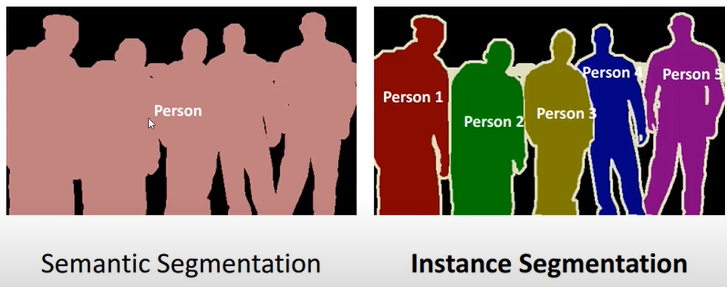

## Instance Segmentation (G1 output)

In [ ]:
plt.imshow((armlabel_map[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)

## Normal segmentation

In [ ]:
plt.imshow((in_label[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)

In [ ]:
plt.imshow((in_mask_clothes[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)

## Ground Truth 

In [ ]:
secondInput = (in_label * (1 - in_mask_clothes)).transpose(0, 1)[0].long()

plt.imshow((secondInput.permute(1,2,0).detach().cpu().numpy() + 1)/2)

## G1 output and ground truth

In [ ]:
figure = plt.figure()
figure.add_subplot(1,2, 1)
plt.imshow((armlabel_map[0].permute(1,2,0).detach().cpu().numpy() + 1)/2)
figure.add_subplot(1,2, 2)
plt.imshow((secondInput.permute(1,2,0).detach().cpu().numpy() + 1)/2)
plt.show(block=True)

In [ ]:
import torch.nn.functional as F

def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht or w != wt:
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=250
    )

    return loss

cross_entropy = cross_entropy2d(arm_label, secondInput)

In [ ]:
print(cross_entropy)

In [ ]:
gt = (in_label * (1 - in_mask_clothes)).transpose(0, 1).long()
combine = torch.cat([armlabel_map.float().cuda(), gt.float().cuda()], 2).squeeze()

In [ ]:
print(gt.size())
print(armlabel_map.size())

In [ ]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs/uniform_all')
writer.add_image('gt', gt[0], 5)
writer.add_image('label', armlabel_map[0], 5)


# Training code

In [ ]:
import models.networks as networks
from util.image_pool import ImagePool
from tensorboardX import SummaryWriter
import util.util as util
import cv2

def gen_noise(shape):
    noise = np.zeros(shape, dtype=np.uint8)
    ### noise
    noise = cv2.randn(noise, 0, 255)
    noise = np.asarray(noise / 255, dtype=np.uint8)
    noise = torch.tensor(noise, dtype=torch.float32)
    return noise.cuda()

def generate_label_plain(inputs):
    size = inputs.size()
    pred_batch = []
    for input in inputs:
        input = input.view(1, 14, 256,192)
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)

    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
    label_batch = pred_batch.view(size[0], 1, 256,192)

    return label_batch

def generate_label_color(inputs):
    label_batch = []
    for i in range(len(inputs)):
        label_batch.append(util.tensor2label(inputs[i], opt.label_nc))
    label_batch = np.array(label_batch)
    label_batch = label_batch * 2 - 1
    input_label = torch.from_numpy(label_batch)
    return input_label

def generate_discrete_label(inputs, label_nc, onehot=True, encode=True):
    pred_batch = []
    size = inputs.size()
    for input in inputs:
        input = input.view(1, label_nc, size[2], size[3])
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)
    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
    label_map = []
    for p in pred_batch:
        p = p.view(1, 256, 192)
        label_map.append(p)
    label_map = torch.stack(label_map, 0)
    if not onehot:
        return label_map.float().cuda()
    size = label_map.size()
    oneHot_size = (size[0], label_nc, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)
    return input_label

writer = SummaryWriter('runs/uniform_all')
G1 = networks.define_Refine(37, 14, opt.gpu_ids)
D1 = networks.define_D(34+14+3, opt.ndf, opt.n_layers_D, opt.norm, opt.no_lsgan,
                             opt.num_D, not opt.no_ganFeat_loss, gpu_ids=opt.gpu_ids)
criterionGAN = networks.GANLoss(use_lsgan=not opt.no_lsgan, tensor=torch.cuda.FloatTensor) 
step = 0
for epoch in range(1, 30):
    for i, data in enumerate(dataloader, start=0):
        batchSize = opt.batchSize
        epoch_iter = opt.batchSize
        
        loss_D_fake=0
        loss_D_real=0
        loss_G_GAN=0
        
        all_clothes_label = changearm(data['label'])
        mask_clothes = torch.FloatTensor((data['label'].cpu().numpy() == 4).astype(np.int))
        mask_fore = torch.FloatTensor((data['label'].cpu().numpy() > 0).astype(np.int))
        img_fore = data['image'] * mask_fore
        in_label = Variable(data['label'].cuda())
        in_edge = Variable(data['edge'].cuda())
        in_img_fore = Variable(img_fore.cuda())
        in_mask_clothes = Variable(mask_clothes.cuda())
        in_color = Variable(data['color'].cuda())
        in_all_clothes_label = Variable(all_clothes_label.cuda())
        in_image = Variable(data['image'].cuda())
        in_pose = Variable(data['pose'].cuda())
        in_image2 = Variable(data['image'].cuda())
        in_mask_fore = Variable(mask_fore.cuda())
        
        arm1_mask = torch.FloatTensor((in_label.cpu().numpy() == 11).astype(np.float)).cuda()
        arm2_mask = torch.FloatTensor((in_label.cpu().numpy() == 13).astype(np.float)).cuda()
        pre_clothes_mask=torch.FloatTensor((in_edge.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
        clothes = in_color * pre_clothes_mask

        shape = pre_clothes_mask.shape

        G1_in = torch.cat([pre_clothes_mask, clothes, all_clothes_label, in_pose, gen_noise(shape)], dim=1)
        arm_label = G1.refine(G1_in) #input data into G1 (cGAN)
        sigmoid = torch.nn.Sigmoid()
        arm_label = sigmoid(arm_label)
        armlabel_map = generate_discrete_label(arm_label.detach(), 14, False)
        secondInput = (in_label * (1 - in_mask_clothes)).transpose(0, 1)[0].long()
        cross_entropy = cross_entropy2d(arm_label, secondInput)
        input_concat = torch.cat((G1_in.detach(), arm_label.detach()), dim=1)
        fake_pool = ImagePool(opt.pool_size)
        fake_query = fake_pool.query(input_concat)
        pred_fake_pool = D1.forward(fake_query)
        loss_D_fake += criterionGAN(pred_fake_pool, False)
        input_concat = torch.cat((G1_in.detach(), masked_label.detach()), dim=1)
        pred_real = D1.forward(input_concat)
        loss_D_real += criterionGAN(pred_real, True)
        pred_fake = D1.forward(torch.cat((G1_in.detach(), arm_label), dim = 1))
        loss_G_GAN += criterionGAN(pred_fake, True)
        paramsG1 = list(G1.parameters())
        optimizer_G = torch.optim.Adam(paramsG1, lr=opt.lr, betas=(opt.beta1, 0.999))
        paramsD1 = list(D1.parameters())
        optimizer_D = torch.optim.Adam(paramsD1, lr=opt.lr, betas=(opt.beta1, 0.999))
        loss_G = loss_G_GAN + torch.mean(cross_entropy)
        loss_D = loss_D_real + loss_D_fake
        step += 1
        writer.add_scalar('loss_d', loss_D, step)
        writer.add_scalar('loss_g', loss_G, step)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        if step % 100 == 0:
            a = generate_label_color(generate_label_plain(input_label)).float().cuda()
            combine = torch.cat([armlabel_map[0], secondInput], 2).squeeze()
            writer.add_image('combine', (combine.data + 1) / 2.0, step)
        if step % 3000 == 0:
            print('saving the latest model (epoch %d, total_steps %d)' % (epoch, total_steps))
            G1.save('modelG1%d%d)' % (epoch, step))

In [ ]:
from util.image_pool import ImagePool

input_concat = torch.cat((G1_in.detach(), arm_label.detach()), dim=1)
fake_pool = ImagePool(opt.pool_size)
fake_query = fake_pool.query(input_concat)
pred_fake_pool = D1.forward(fake_query)

In [ ]:
pred_fake_pool

In [ ]:
loss_D_fake=0
loss_D_real=0
criterionGAN = networks.GANLoss(use_lsgan=not opt.no_lsgan, tensor=torch.cuda.FloatTensor) 
loss_D_fake += criterionGAN(pred_fake_pool, False)
loss_G_GAN=0

In [ ]:
loss_D_fake

In [ ]:
input_concat = torch.cat((G1_in.detach(), masked_label.detach()), dim=1)
pred_real = D1.forward(input_concat)

In [ ]:
pred_real

In [ ]:
loss_D_real += criterionGAN(pred_real, True)

In [ ]:
loss_D_real

In [ ]:
pred_fake = D1.forward(torch.cat((G1_in.detach(), arm_label), dim = 1))
loss_G_GAN += criterionGAN(pred_fake, True)

In [ ]:
feat_weights = 4.0 / (opt.n_layers_D + 1)
D_weights = 1.0 / opt.num_D
for i in range(opt.num_D):
    for j in range(len(pred_fake[i])-1):
        loss_G_GAN_Feat += D_weights * feat_weights * \
            self.criterionFeat(pred_fake[i][j], pred_real[i][j].detach()) * opt.lambda_feat

In [ ]:
loss_G = loss_G_GAN + torch.mean(cross_entropy)

In [ ]:
loss_D = loss_D_real + loss_D_fake

In [ ]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs/uniform_all')
writer.add_scalar('loss_d', loss_D, step)
writer.add_scalar('loss_g', loss_G, step)

In [ ]:
params = list(G1.parameters())
optimizer_G = torch.optim.Adam(params, lr=opt.lr, betas=(opt.beta1, 0.999))